In [4]:
from google.colab import drive
from google.colab import files

#Read and write files directly from google drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#install packages missing from the Colab environment
!pip install geopandas
!pip install rasterio

In [0]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import mapping, shape
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import math

#from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
#import matplotlib.font_manager as fm

In [0]:
#Define a Bounding Boxes class to store all calculations and methods for plotting
class Bounding_Boxes:

  #Instantiate Bounding_Boxes class using vector data - this class is written specifically to accept volcano specific data
  def __init__(self, vector_data):
    
    #Add vector_data attribute to inspect original vector data
    self.vector_data = vector_data
    
    bbox = {}
    bbox['Archipelago'] = vector_data.total_bounds
    
    isabela_list = ['Darwin', 'Alcedo', 'Ecuador', 'South', 'Wolf']
    
    bbox['Isabela'] = vector_data[vector_data['Name'].isin(isabela_list)].total_bounds
    
    for island in list(vector_data.Name.unique()):
      bbox[island] = vector_data[vector_data['Name']==island].envelope
    self.bboxes = bbox
    
    #Add volcano_names class to inspect all unique volcano names (useful for plotting)
    volcano_names = list(vector_data.Name.unique()) + ['Archipelago'] + ['Isabela']
    self.volcano_names = volcano_names
      
  #Define a method to create matplotlib compatible xlim
  def x_lim_island(self, island, zoom_factor=0.15):
    
    #Define the factor by which to zoom out x axis (this could be made into two zooms L & R)
    #z_factor = 0.15 means that 15% of the total boundign box will be added to both sides
    #This scales with the size of the island to add a border to all plots
    z_factor = zoom_factor
    
    #Archipelago is a ndarray data type not a Shapely Polygon
    if island in ['Archipelago', 'Isabela']:
      xmin = self.bboxes[island][0]
      xmax = self.bboxes[island][2]
    
      zoom = (xmax - xmin) * z_factor
      
      #Returns xlim ready for the plt.xlim function
      return(xmin - zoom, xmax + zoom)
    
    #Extract coordinates from Shapely Polygon bounding boxes
    else:
      xmin = mapping(self.bboxes[island])['bbox'][0]
      xmax = mapping(self.bboxes[island])['bbox'][2]
  
      zoom = (xmax - xmin) * z_factor
    
      #Returns xlim ready for the plt.xlim function    
      return(xmin - zoom, xmax + zoom)

  #Copy of x_lim_island for the y axis
  def y_lim_island(self, island, zoom_factor=0.15):
  
    z_factor = zoom_factor
  
    if island in ['Archipelago', 'Isabela']:
      ymin = self.bboxes[island][1]
      ymax = self.bboxes[island][3]
    
      zoom = (ymax - ymin) * z_factor
      
      return(ymin - zoom, ymax + zoom)
  
    else:
      ymin = mapping(self.bboxes[island])['bbox'][1]
      ymax = mapping(self.bboxes[island])['bbox'][3]
    
      zoom = (ymax - ymin) * z_factor
  
      return(ymin - zoom, ymax + zoom) 

In [0]:
volcanoes = gpd.read_file('drive/My Drive/Hamish mapping/Hamish mapping/Environmental layers/Shp/Island_volcanos_wgs.shp', 
                          driver='ESRI Shapefile')
coastline = gpd.read_file('drive/My Drive/Hamish mapping/Hamish mapping/useful general mapping data - elevation and perimeter/Linea_Costa/PERFIL_Project.shp', 
                       driver='ESRI Shapefile')
hillshade = rasterio.open('drive/My Drive/Hamish mapping/Hamish mapping/tmp/hillshade.tif')
island_boxes = Bounding_Boxes(volcanoes)

In [0]:
from math import radians, degrees, sin, cos, asin, acos, sqrt

def great_circle(lon1, lat1, lon2, lat2):
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
  
  return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))
  
def dirty_inverse(kilometer_value):
  return((1.0/111.0)*(float(kilometer_value)))

In [0]:
'''
To make a scale bar:

Going to locate scale bar on bottom R of image

- need to know the width of the entire image, we are near the equator and using geographic coordinates so can approximate with a sphere
- need to know the x coordinates of a bar of a representative size (some fraction of the image?) to act as scale bar
- plot this bar (line) at these x coordinates and some y coords a standard distance from the bottom of the image

To calculate:

- total width of the image X
- coordinate some set distance from the max x coord (where R side of scale bar will stop)
- coordinate a representative distance to L of the start x coord - must be a whole number

Try:
compute distance of one fifth of the image, select the value closest to this distance from a list, 
plot the bar the length of that value (in degrees) from the max x coord of the scale bar

'''

In [0]:
def scale_bar(min_x, min_y, max_x, max_y, scale_x_buffer=0.125, scale_y_buffer=0.05):
  
  '''
  Define the line that will be a distance measure on the map
  '''
  
  #List of possible labels for the scale bar
  scale_bar_labels = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100]
  
  #Determine the width and height of the plot in degrees
  width_degrees = max_x - min_x
  height_degrees = max_y - min_y
  
  #Determine the x and y buffer for the scale bar
  scale_x_buffer = width_degrees * scale_x_buffer
  scale_y_buffer = height_degrees * scale_y_buffer
  
  #Determine the location of the bottom corners (L & R) of the map
  left_map_point = [min_x, min_y]
  right_map_point = [max_x, min_y]
  
  #Determine the width of the map in kilometers
  map_width_km = great_circle(left_map_point[0], left_map_point[1],
                            right_map_point[0], right_map_point[1])
  
  #Determine the right x coordinate of the scale bar
  scale_R_coord = island_boxes.x_lim_island(island_to_plot)[1] - scale_x_buffer
  
  #Make the scale bar approximately 1/5th of image by default
  scale_bar_image_fraction = 0.2

  #Compute distance of 1/5 of image in kilometers
  scale_relative_length = map_width_km * scale_bar_image_fraction

  #Find the value in scale_bar_labels closest to this value (scale_relative_length)
  closest_scale_bar_label = min(scale_bar_labels, key=lambda x:abs(x-scale_relative_length))
  
  #Do an inverse great circle distance computation (rather crude) to convert closest_scale_bar_label from degrees to km
  degree_shift = dirty_inverse(closest_scale_bar_label)
  
  #use degree_shift to compute the left x coordinate of the scale bar
  scale_L_coord = scale_R_coord - degree_shift
  
  #Determine the y coordinate for both the R and L corners of the scale bar
  scale_y_coord = min_y + scale_y_buffer
  
  '''
  Add white lines to scale bar at 0.25 to 0.5, and 0.75 to 1.0
  '''
  
  #Find the x coordinate of 6 points along the scale bar line
  sextiles = np.linspace(scale_L_coord, scale_R_coord, 6)
  
  #Define the x coordinates for the two white patches on the line
  white1_x_coords = (sextiles[1], sextiles[2])
  white2_x_coords = (sextiles[3], (sextiles[4]))
  
  '''
  Add text to the scale bar
  '''
  
  #Define the height of the text (half of the distance between the scale bar and the plot frame)
  text_y_coordinate = scale_y_coord - (scale_y_buffer/2)
  
  #Define a middle text label 1/3 of the way from 0 to closest_scale_bar_label
  middle_text_label = round(np.linspace(0, closest_scale_bar_label, 6)[2], 1)
  
  #If the middle_text_label has no decimal place, convert it to an integer
  if middle_text_label.is_integer():
    middle_text_label = int(middle_text_label)
  
  
  #return([((scale_R_coord - degree_shift), scale_R_coord), (scale_y_coord, scale_y_coord)])
  return(
      plt.plot((scale_L_coord, scale_R_coord), (scale_y_coord, scale_y_coord), color='k', linestyle='-', linewidth=4),
      plt.plot(white1_x_coords, (scale_y_coord, scale_y_coord), color='w', linestyle='-', linewidth=2.5),
      plt.plot(white2_x_coords, (scale_y_coord, scale_y_coord), color='w', linestyle='-', linewidth=2.5),
      plt.text(scale_L_coord, text_y_coordinate, '0', ha='center'),
      plt.text(sextiles[2], text_y_coordinate, str(middle_text_label), ha='left'),
      plt.text(scale_R_coord, text_y_coordinate, str(closest_scale_bar_label) + ' km', ha='left')
  )
  

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


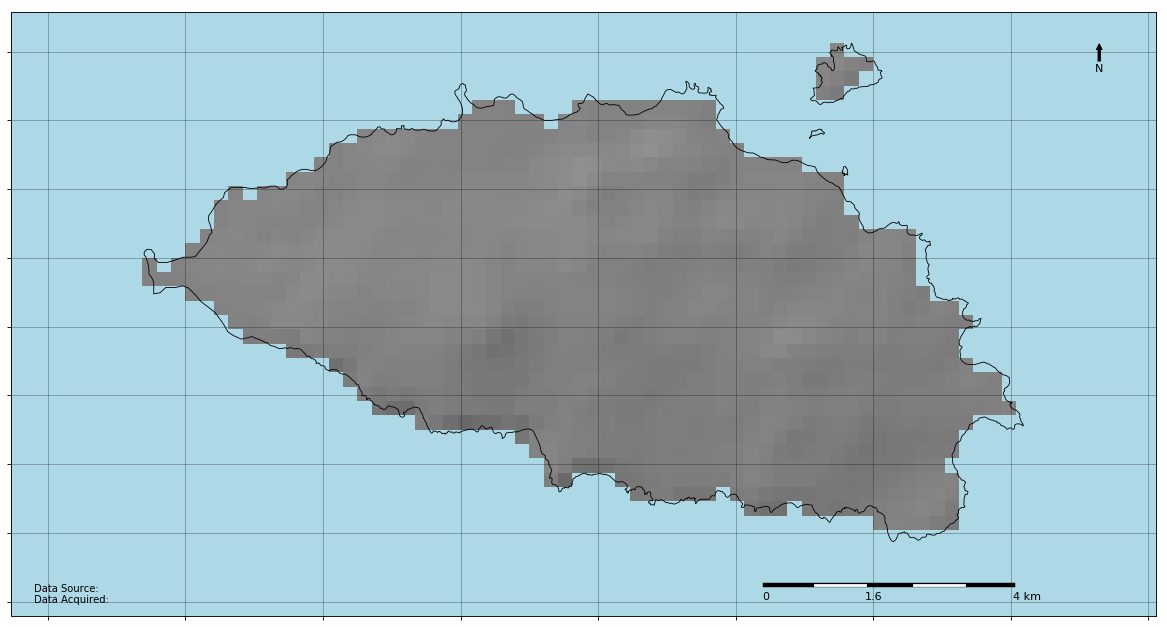

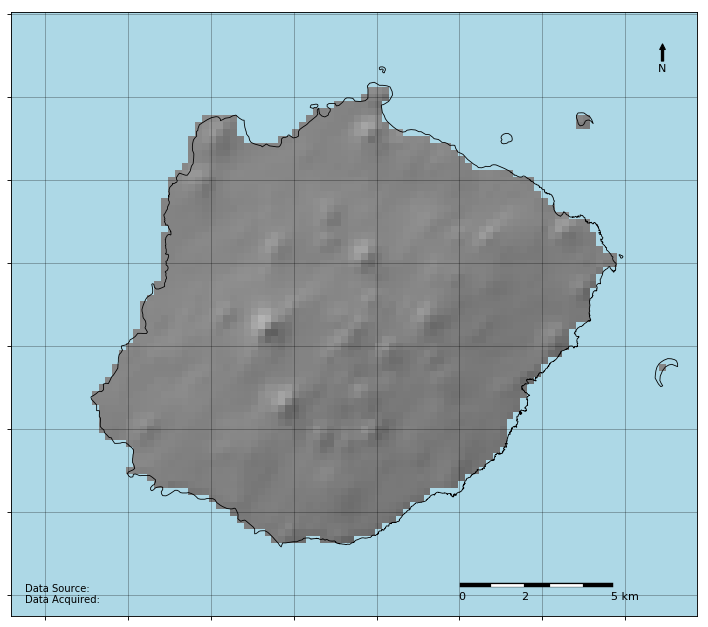

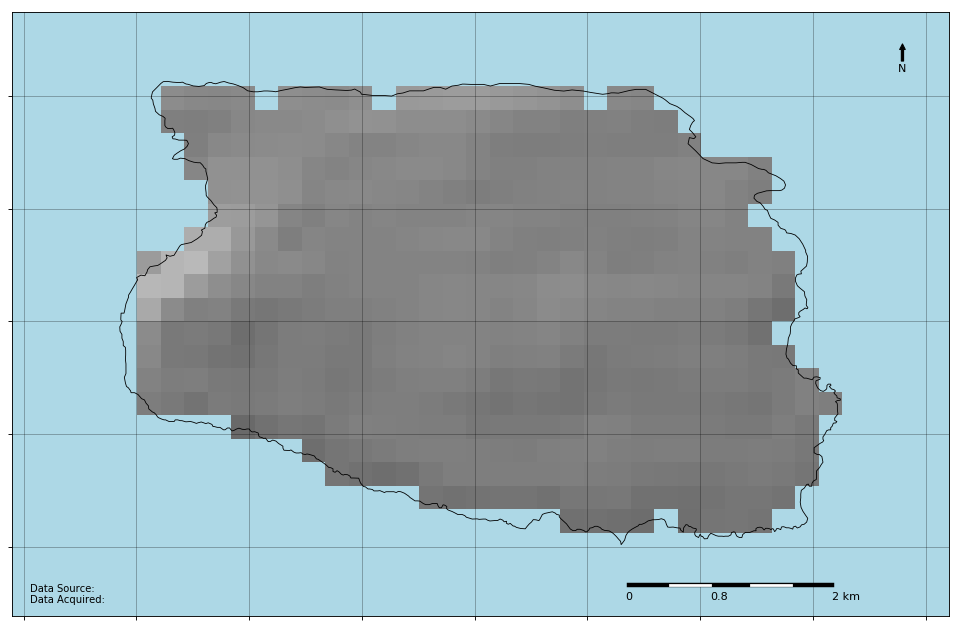

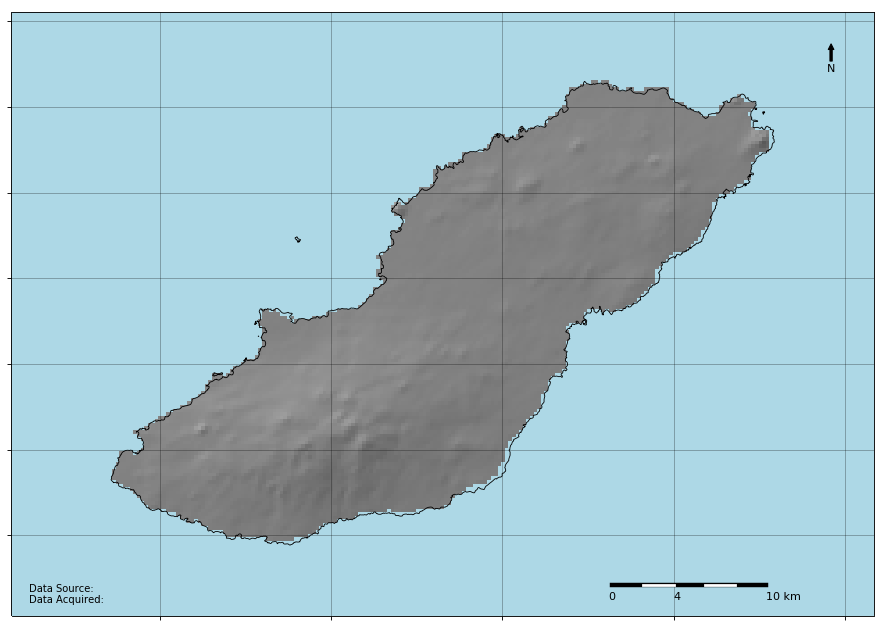

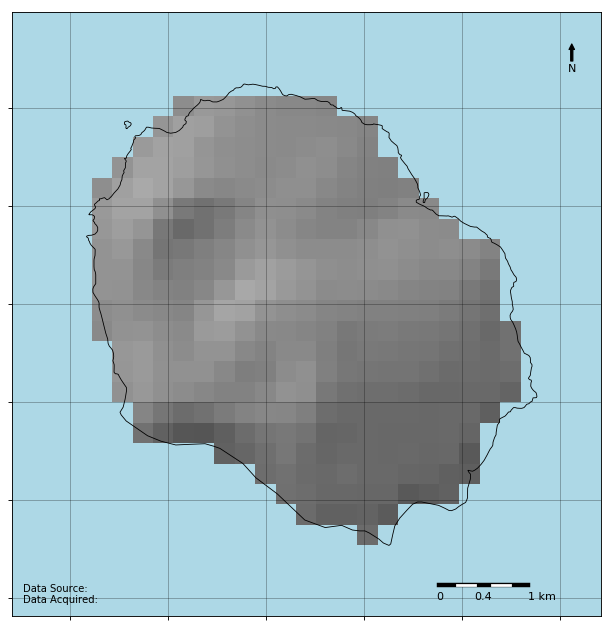

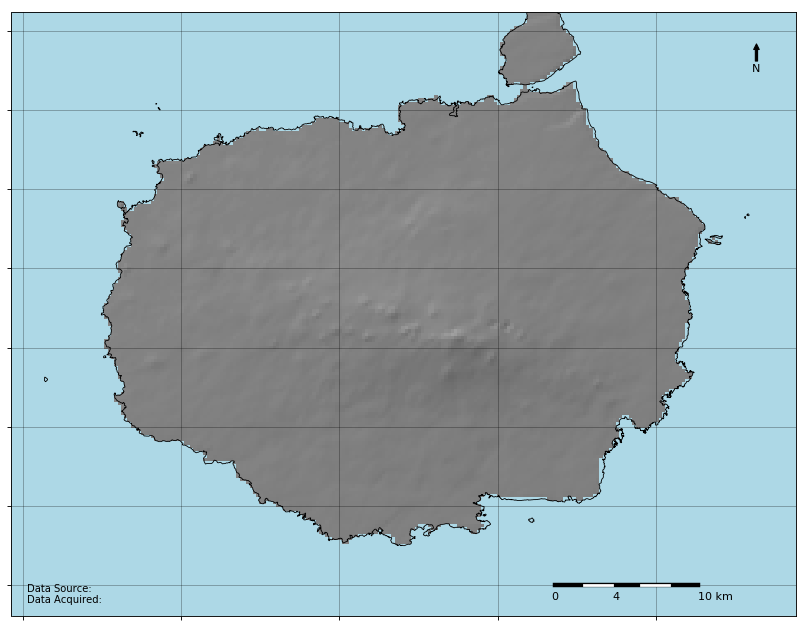

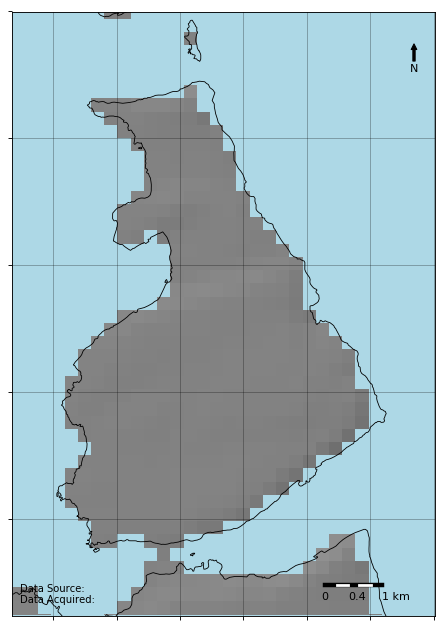

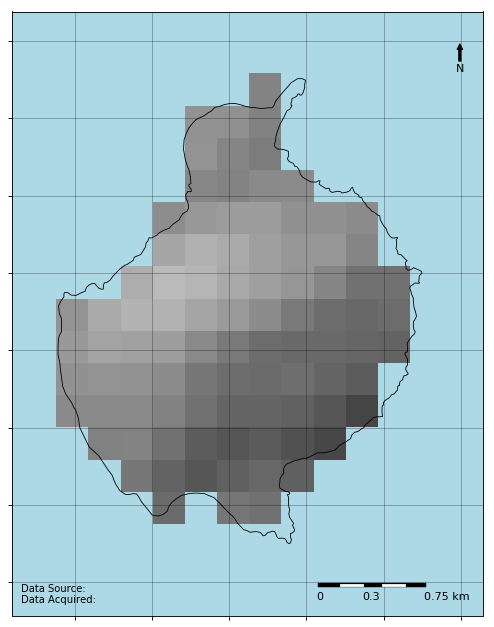

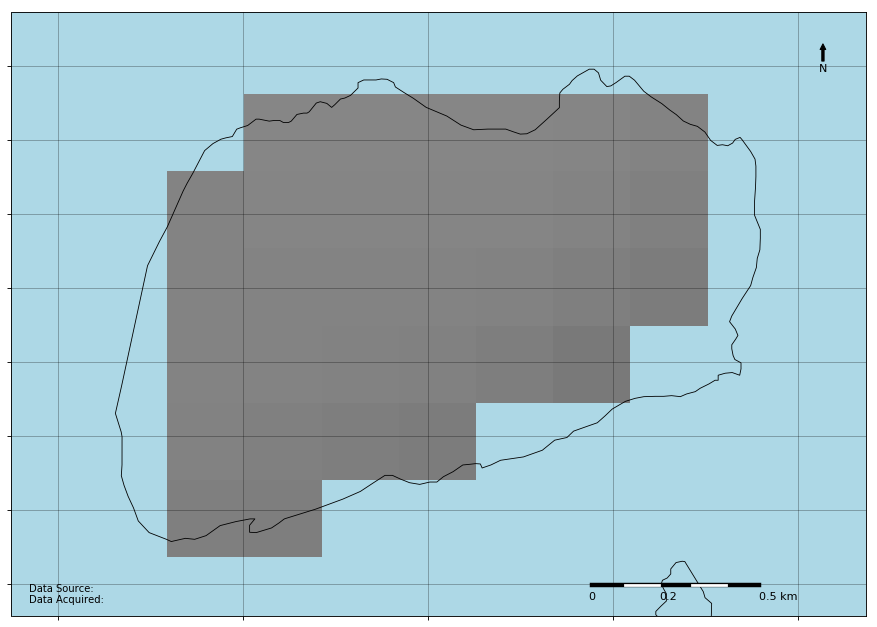

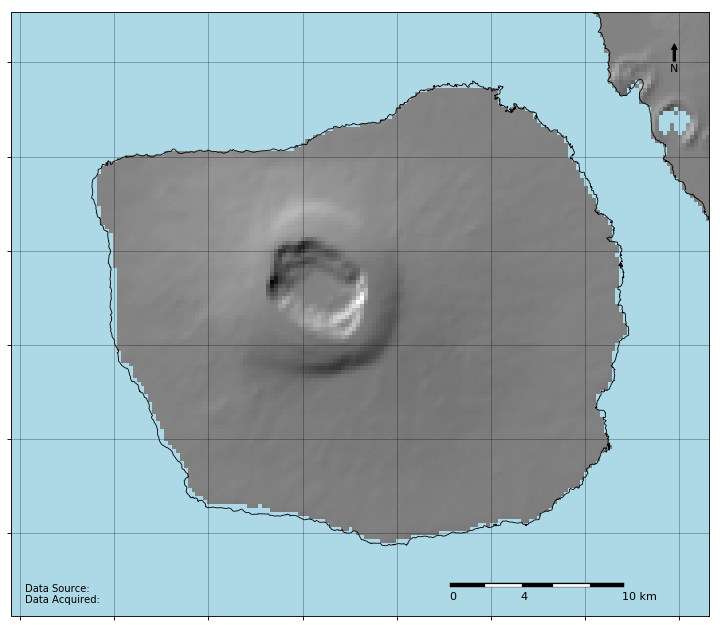

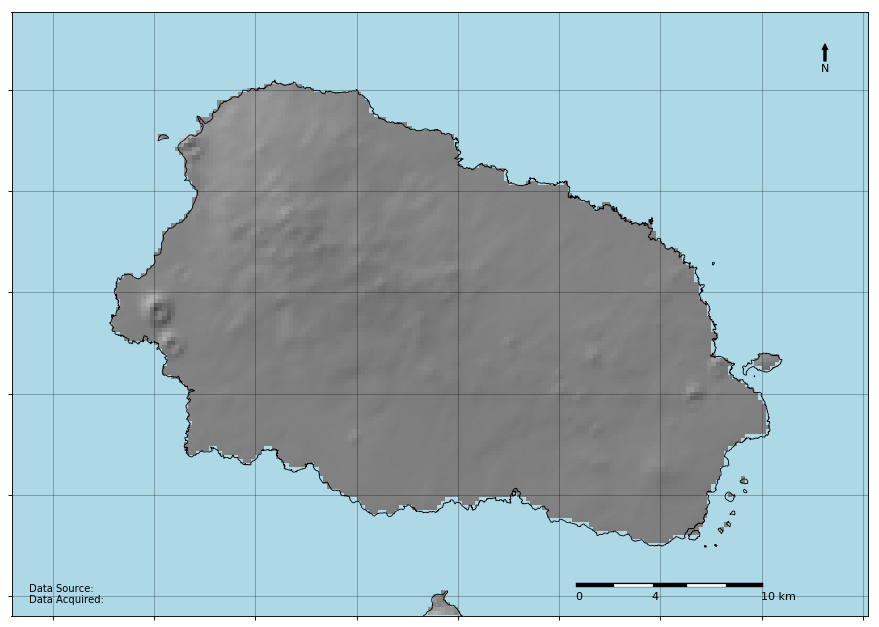

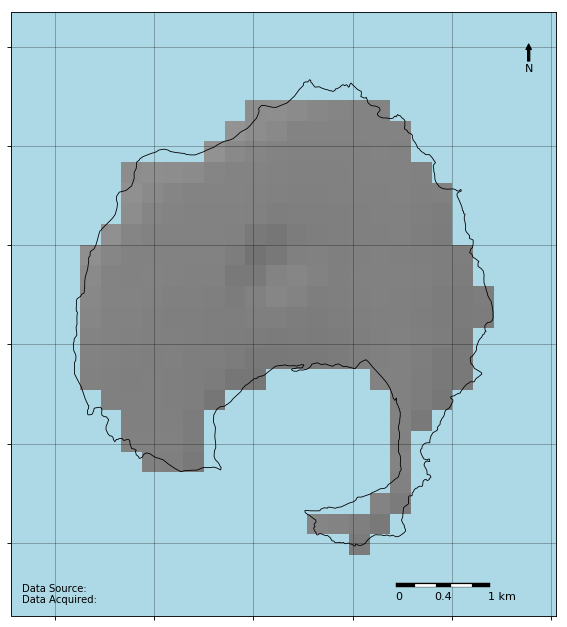

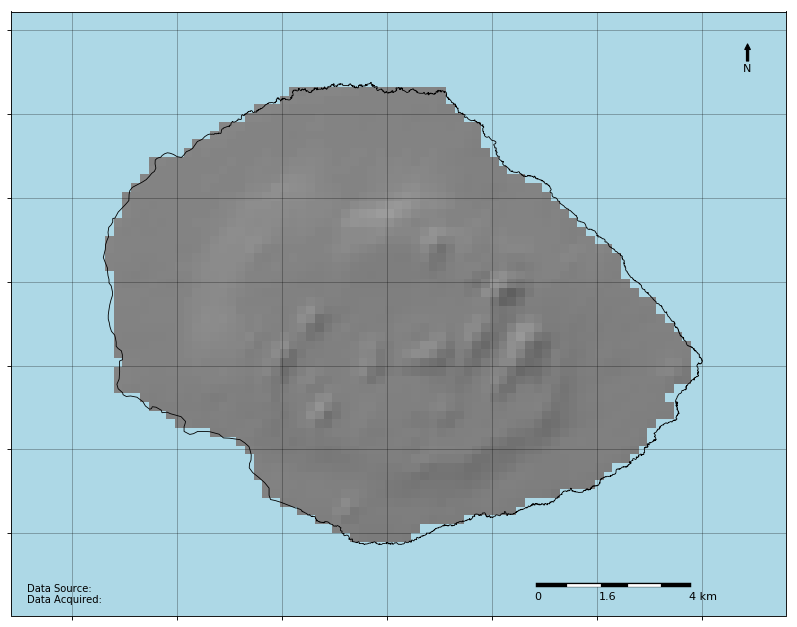

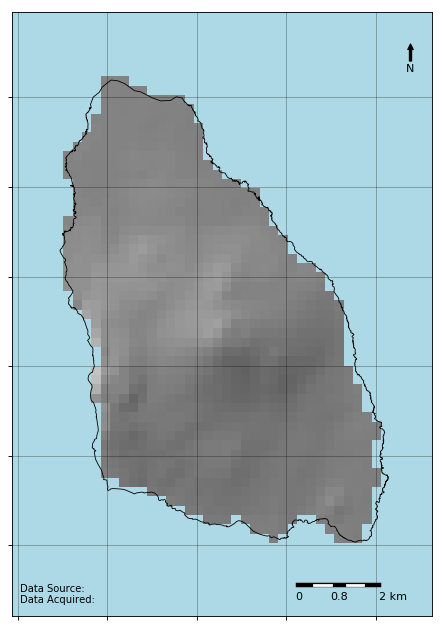

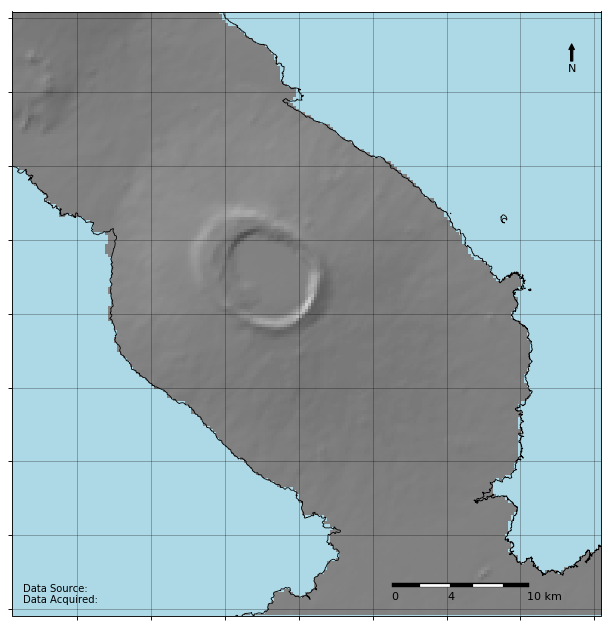

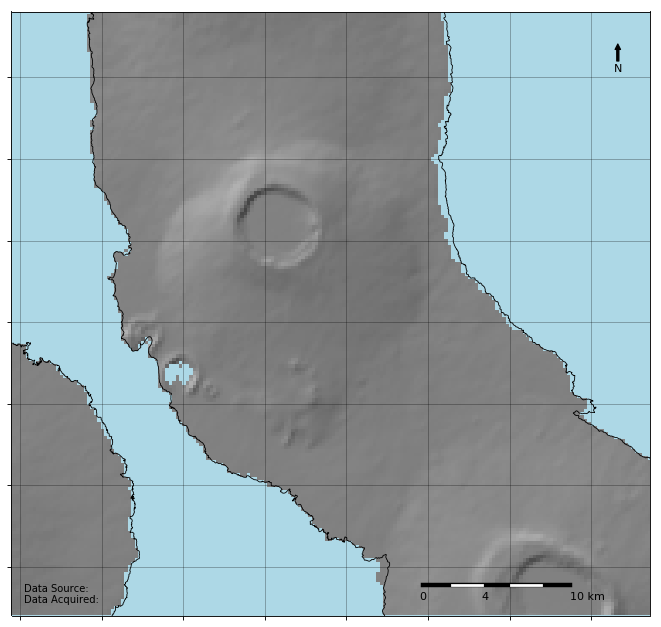

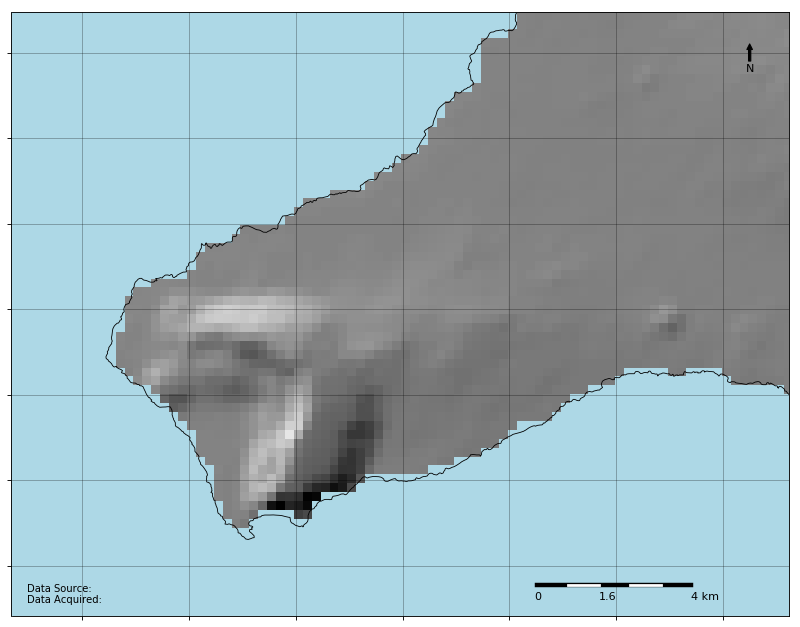

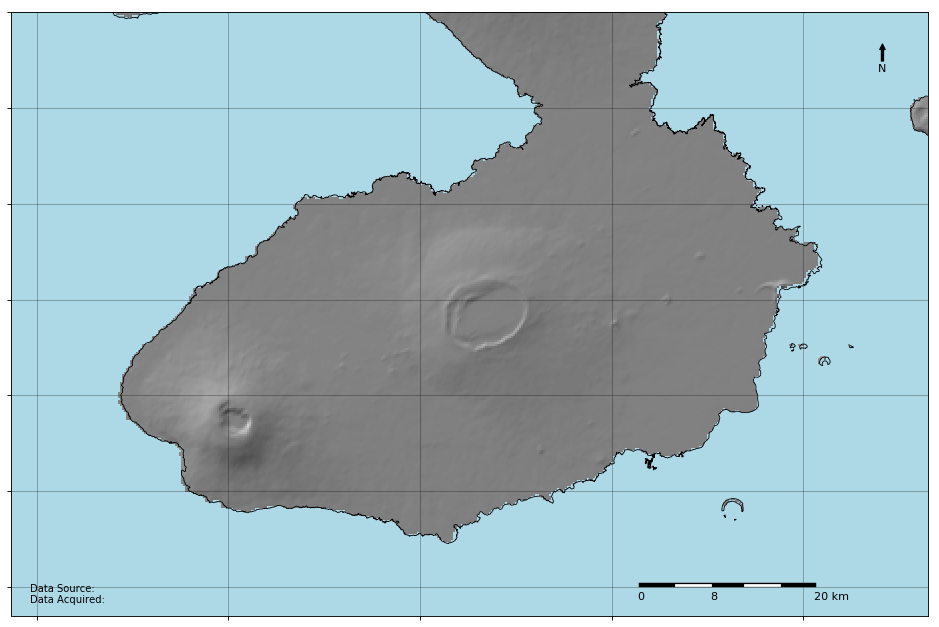

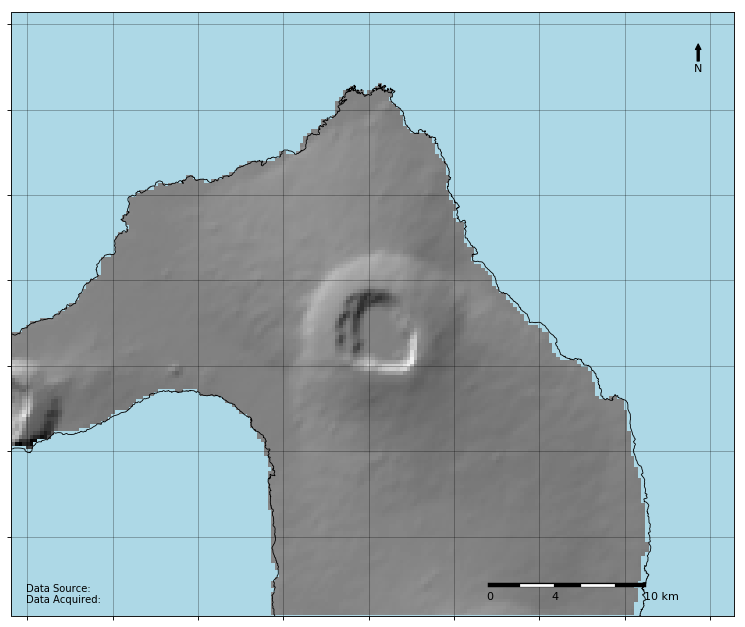

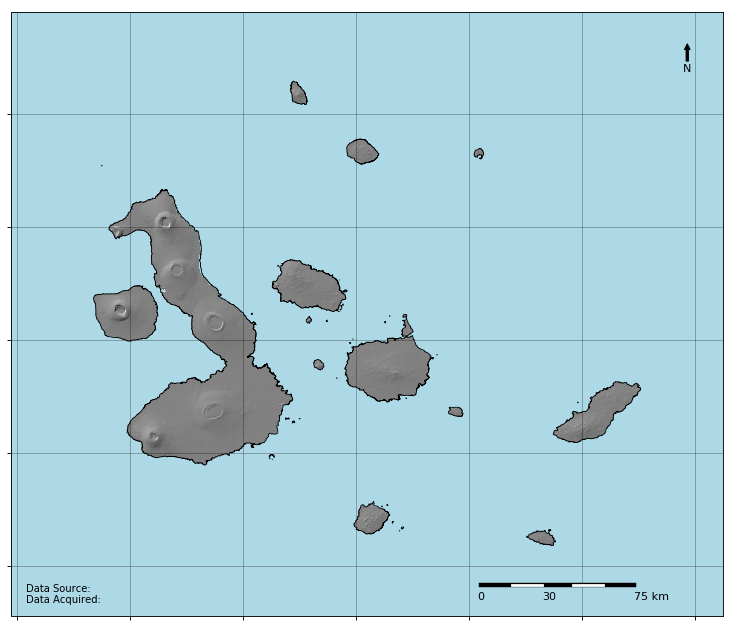

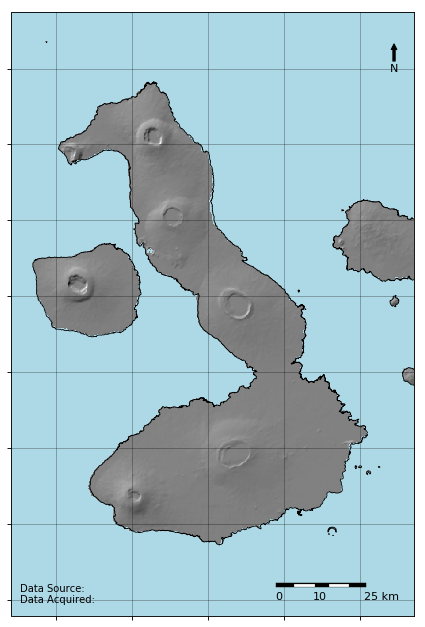

In [110]:
for island in island_boxes.volcano_names:
  island_to_plot = island

  plt.rcParams["figure.figsize"] = [20,10]
  plt.rcParams["figure.dpi"] = 80

  #Add data
  ax = coastline.geometry.plot(color='k', linewidth=0.75)

  ax.imshow(hillshade.read(1), 
            extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
            cmap='gray')

  #Add styling
  ax.grid(True, color='k', alpha=0.3)
  ax.set_facecolor('lightblue')

  arrow_buffer = 0.05

  x_diff = island_boxes.x_lim_island(island_to_plot)[1] - island_boxes.x_lim_island(island_to_plot)[0]
  arrow_x = island_boxes.x_lim_island(island_to_plot)[1] - (x_diff * arrow_buffer)
  y_diff = island_boxes.y_lim_island(island_to_plot)[1] - island_boxes.y_lim_island(island_to_plot)[0]
  arrow_y = island_boxes.y_lim_island(island_to_plot)[1] - (y_diff * arrow_buffer)

  text_x_buffer = x_diff / 50
  text_y_buffer = y_diff / 50

  ax.text(x=island_boxes.x_lim_island(island_to_plot)[0] + text_x_buffer,
          y=island_boxes.y_lim_island(island_to_plot)[0] + text_y_buffer,
          s='Data Source:\nData Acquired:', size=9)

  ax.annotate('', xy=(arrow_x, arrow_y), xytext=(arrow_x, (arrow_y-(y_diff/28))), arrowprops=dict(arrowstyle='simple', fc='k'), clip_on=True)

  ax.text(x=arrow_x, y=(arrow_y-(y_diff/20)),
          s='N', horizontalalignment='center')

  #Additional formatting
  plt.xlim(island_boxes.x_lim_island(island_to_plot))
  plt.ylim(island_boxes.y_lim_island(island_to_plot))

  scale_bar(island_boxes.x_lim_island(island_to_plot)[0],
              island_boxes.y_lim_island(island_to_plot)[0],
              island_boxes.x_lim_island(island_to_plot)[1],
              island_boxes.y_lim_island(island_to_plot)[1])

  ax.axes.get_xaxis().set_ticklabels([])
  ax.axes.get_yaxis().set_ticklabels([])
  
  path = 'drive/My Drive/Hamish mapping/Plot_Tests/'
  fn = island + '_Scale_Test.png'
  
  plt.savefig(path + fn, dpi=80)
  #color references:
  #https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
  #https://matplotlib.org/3.1.0/gallery/color/named_colors.html